In [1]:
import torch
print(torch.__version__)
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn

2.6.0+cu124


# Download Dataset using datasets & Dataloader

In [2]:
train_dataset = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [3]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

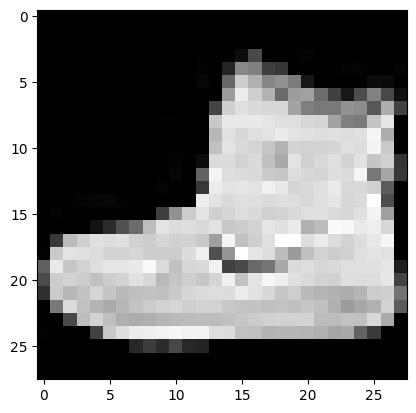

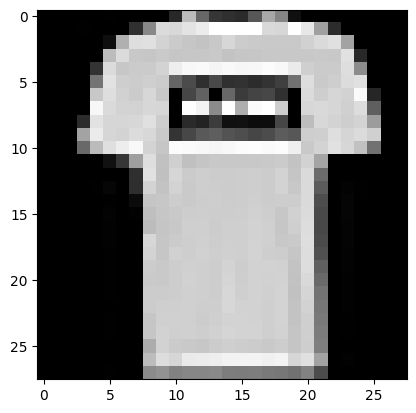

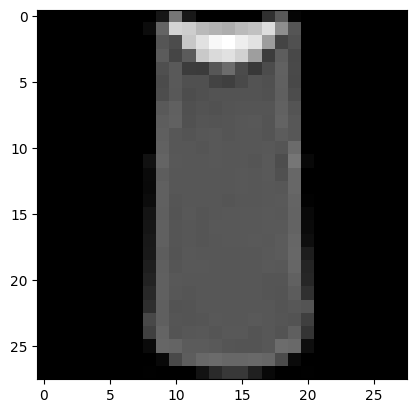

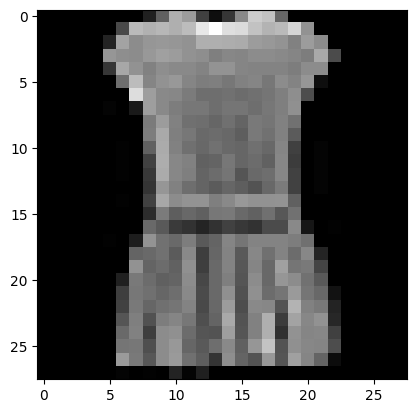

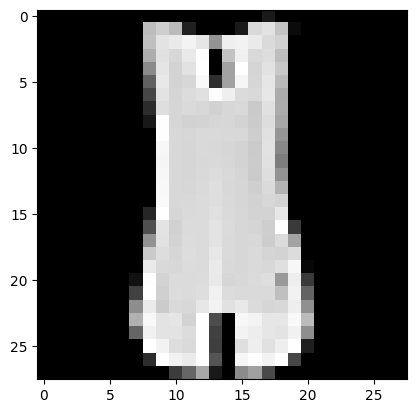

In [4]:
for i in range(5):
  image,label = train_dataset[i]
  plt.imshow(image.squeeze(),cmap="grey")
  plt.show()

In [5]:
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Define TinyVGG Model

In [6]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=output_shape,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
    )

  def forward(self,x):
      x = self.block_1(x)
      x = self.block_2(x)
      x = self.classifier(x)
      return x


torch.manual_seed(42)
model_tinyVgg = TinyVGG(input_shape=1,hidden_units=10,output_shape=len(class_names))
model_tinyVgg

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_tinyVgg.parameters(),lr=0.1)

In [9]:
torch.manual_seed(42)

epochs = 3

for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-------")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model_tinyVgg.train()

    y_pred = model_tinyVgg(X)

    loss = loss_fn(y_pred,y)
    train_loss+=loss
    train_acc = accuracy_fn(y_true=y,
                            y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
  train_loss /= len(train_dataloader)

  test_loss,test_acc=0,0
  model_tinyVgg.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      test_pred = model_tinyVgg(X)

      test_loss += loss_fn(test_pred,y)
      test_acc +=accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")



Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59046 | Test loss: 0.39489, Test acc: 85.89%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.36374 | Test loss: 0.35389, Test acc: 86.95%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.32599 | Test loss: 0.32281, Test acc: 88.21%



# Make predictions


In [10]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [11]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):  #test_dataset
    test_samples.append(sample)
    test_labels.append(label)

In [12]:
pred_probs= make_predictions(model=model_tinyVgg,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

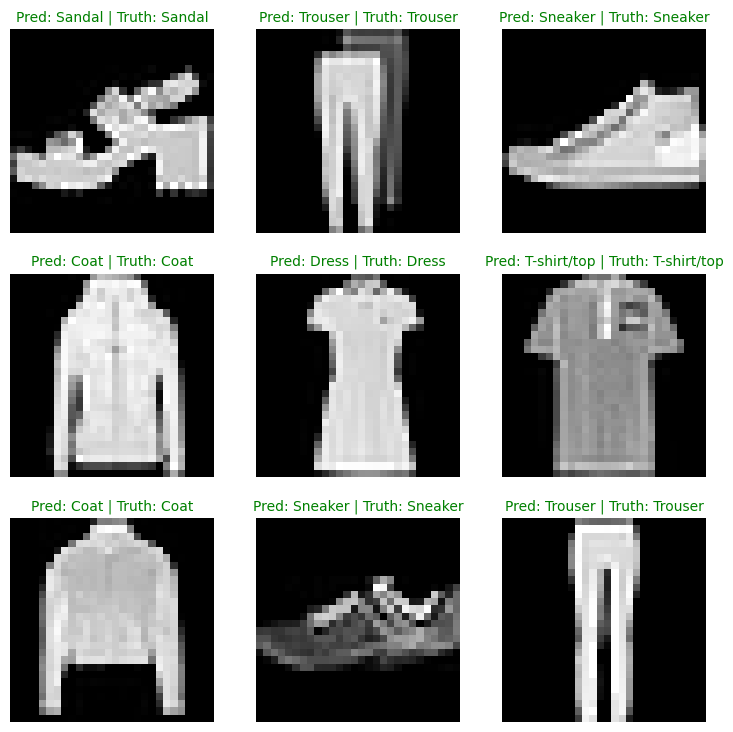

In [13]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);